In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
import scipy.integrate as integrate
import scipy.optimize as optimize

In [2]:
plt.style.use("../style1.mplstyle")

In [3]:
@njit
def chemostat_dynamics(t,y,args):
    mu,k,yiel,delta,s = args
    n,c = y
    dn = mu * n * c / (k + c) - delta * n
    dc = delta*(s-c) - mu * n/yiel * c / (k + c)

    return np.array([dn,dc])

In [112]:
mu = 0.2
delta = 0.05
k = 4
s = 100
yiel = 0.1

In [212]:
initialn = 0.05
initialc = s
teval = np.linspace(0,72,1000)

In [213]:
soln_n = integrate.solve_ivp(chemostat_dynamics, (0,teval[-1]), [initialn,initialc], args=((mu,k,yiel,delta,s),), t_eval=teval)

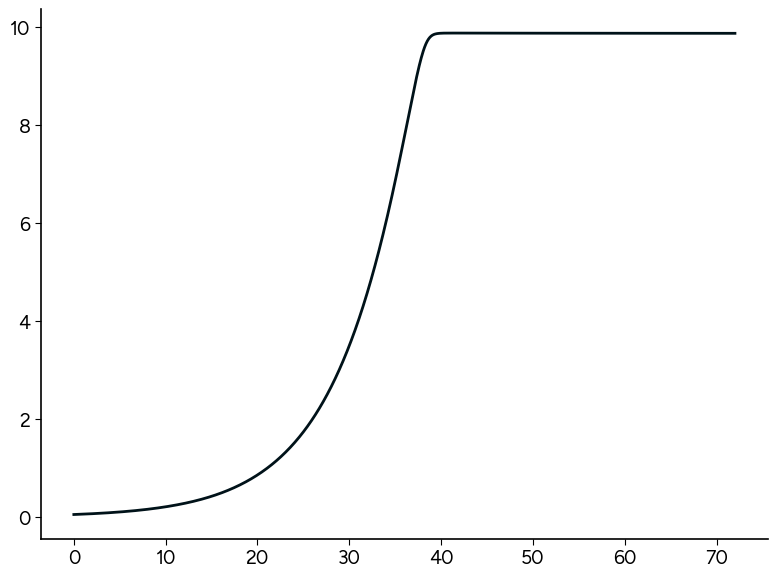

In [214]:
plt.plot(teval,soln_n.y[0],label="OD")


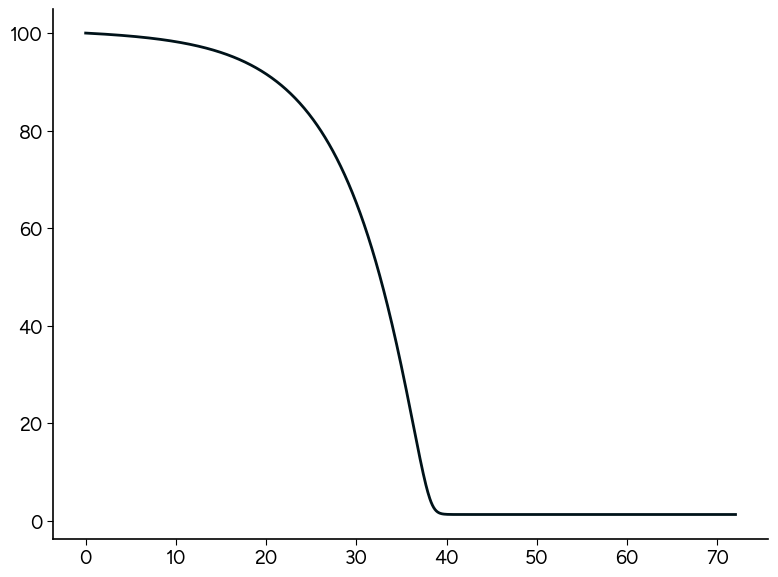

In [215]:
plt.plot(teval,soln_n.y[1],label="Resource")


In [216]:
@njit
def glv_rhs(t,y,g,alpha):
    dydot = y*(g - alpha*y)
    return dydot

In [217]:
def logistic_solution(t,g,alpha,x0):
    return x0 * g/alpha  / ((g/alpha - x0)*np.exp(-g*t) + x0)

theory_soln = lambda t,g,alpha: logistic_solution(t,g,alpha,initialn)

In [218]:
def glv_error(params,chemostatSoln):
    gvec,alphamatrix = params
    integrated_soln = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(gvec,alphamatrix),t_eval=teval,rtol=1e-6,atol=1e-6)
    try:
        error = np.sum((integrated_soln.y[0] - chemostatSoln)**2)
    except:
        print(params)
        integrated_soln
    return np.sum((integrated_soln.y[0] - chemostatSoln)**2)

In [219]:
glv_lsq = optimize.minimize(glv_error,[0.1,0.1],args=(soln_n.y[0]),method="Nelder-Mead",bounds=[(0,None),(0,None)])

g,alpha = glv_lsq.x

print(g,alpha)

0.16962110618566678 0.01649444043769175


In [220]:
soln_glv_bootstrap = integrate.solve_ivp(glv_rhs,[0,teval[-1]],[initialn],args=(g,alpha),t_eval=teval,rtol=1e-6,atol=1e-6)

In [221]:
fitvals,fitcorr  = optimize.curve_fit(theory_soln,teval,soln_n.y[0],p0=[1,1],bounds=([0,0],[np.inf,np.inf]))

g,alpha = fitvals
print(g,alpha)

soln_glv_theoryfit = integrate.solve_ivp(glv_rhs, (0,teval[-1]), [initialn], args=(g,np.array([[alpha]])), t_eval=teval)

0.1696186022970538 0.016493758236875072


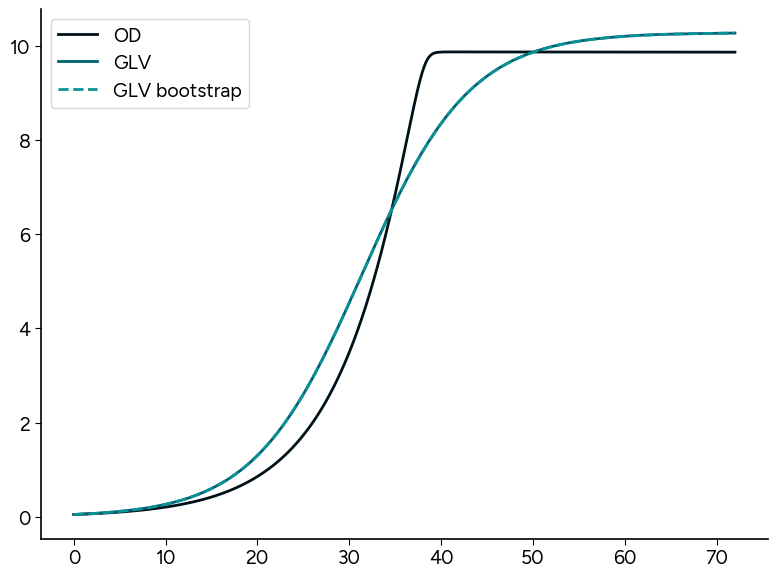

In [222]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(teval,soln_glv_theoryfit.y[0],label="GLV")
plt.plot(teval,soln_glv_bootstrap.y[0],label="GLV bootstrap",ls="--")

plt.legend()

In [223]:
def glv_approx_params(c,mu,k,yiel,delta,s):
    sij = mu*k / (k+c)**2
    fi = delta*(s-c) 
    df_de = -delta
    eC = mu*c / (k+c) / yiel
    de_dE = mu*k / (k+c)**2 / yiel

    mij = de_dE / eC * fi - df_de
    gcalc = fi / mij / sij
    alphacalc = eC / sij/mij
    return gcalc,alphacalc

In [224]:
def third_order_approx(c,mu,k,yiel,delta,s):
    sij = mu*k / (k+c)**2
    fi = delta*(s-c) 
    df_de = -delta
    eC = mu*c / (k+c) / yiel
    de_dE = mu*k / (k+c)**2 / yiel

    minv = 1/delta * (1+ mu*k*f/eC / delta / yiel / (k+c)**2)
    gcalc = fi *minv / sij
    alphacalc = eC / sij * minv
    return gcalc,alphacalc

In [225]:
def qssC(n,mu,k,yiel,delta,s):
    bterm = (-s + k + n*mu/delta/yiel)
    aterm = 1
    cterm = -s * k
    return (-bterm + np.sqrt(bterm**2 - 4*aterm*cterm))/(2*aterm)

In [226]:
qssCvsT = np.array([qssC(n,mu,k,yiel,delta,s) for n in soln_n.y[0]])

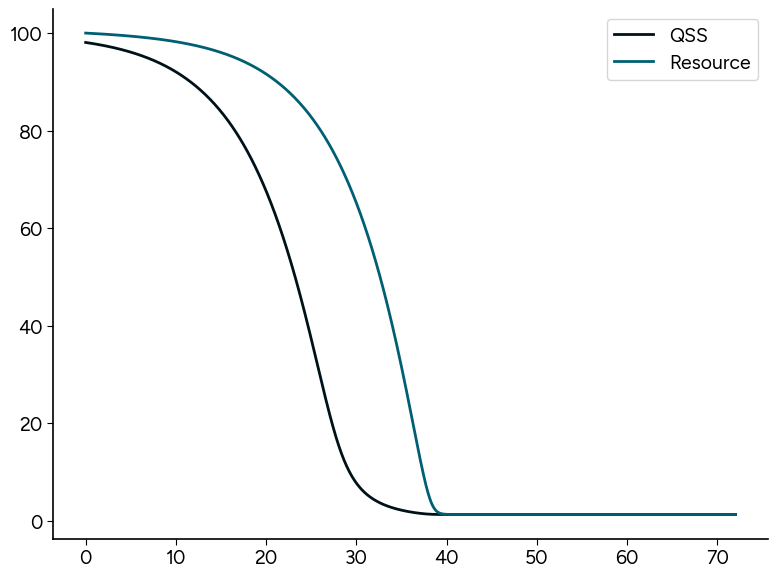

In [227]:
plt.plot(teval,qssCvsT,label="QSS")
plt.plot(teval,soln_n.y[1],label="Resource")

plt.legend()

In [228]:
paramsOfApprox = glv_approx_params(qssCvsT[-1],mu,k,yiel,delta,s)
paramsApproxTimeTraj = np.array([glv_approx_params(c,mu,k,yiel,delta,s) for c in qssCvsT])

In [231]:
@njit
def timeDepGLV(t,y,gTime,alphaTime):
    indexT = np.where(teval >= t)[0][0]
    g,alpha = gTime[indexT],alphaTime[indexT]
    return y*(g - alpha*y)

In [232]:
gTime = paramsApproxTimeTraj[:,0]
alphaTime = paramsApproxTimeTraj[:,1]

In [233]:
@njit
def rk4Integrator(func,t,y,dt,args):
    k1 = dt*func(t,y,*args)
    k2 = dt*func(t+dt/2,y+k1/2,*args)
    k3 = dt*func(t+dt/2,y+k2/2,*args)
    k4 = dt*func(t+dt,y+k3,*args)
    return y + (k1 + 2*k2 + 2*k3 + k4)/6

In [235]:
tineDependentGLV = integrate.solve_ivp(timeDepGLV,[0,teval[-1]],[initialn],args=(gTime,alphaTime),t_eval=teval)

In [236]:
tineDependentGLV

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  7.207e-02 ...  7.193e+01  7.200e+01]
        y: [[ 5.000e-02  5.066e-02 ...  9.866e+00  9.869e+00]]
      sol: None
 t_events: None
 y_events: None
     nfev: 6989234
     njev: 0
      nlu: 0

In [186]:
timeDepN = np.zeros_like(soln_n.y[0])
timeDepN[0] = initialn
dt = teval[1] - teval[0]

for i in range(1,len(teval)):
    timeDepN[i] = rk4Integrator(timeDepGLV,teval[i-1],timeDepN[i-1],dt,(gTime[i-1],alphaTime[i-1]))
    

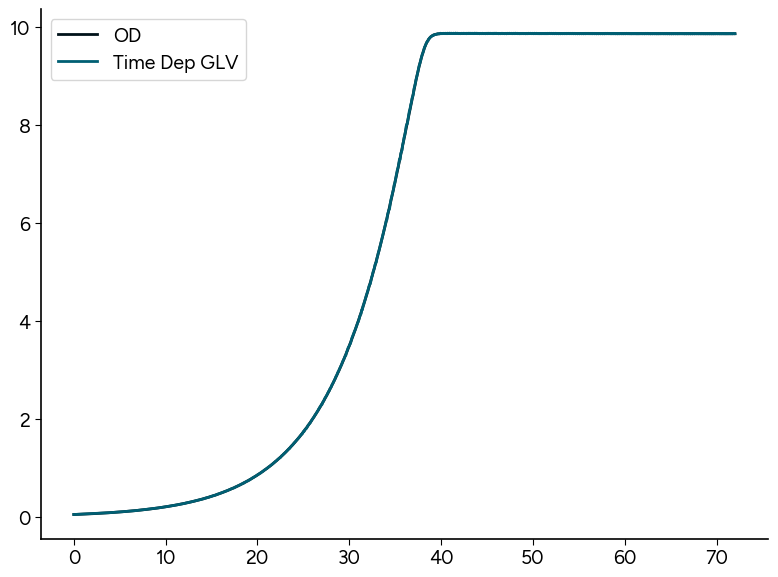

In [239]:
plt.plot(teval,soln_n.y[0],label="OD")
plt.plot(teval,tineDependentGLV.y[0],label="Time Dep GLV")

plt.legend()

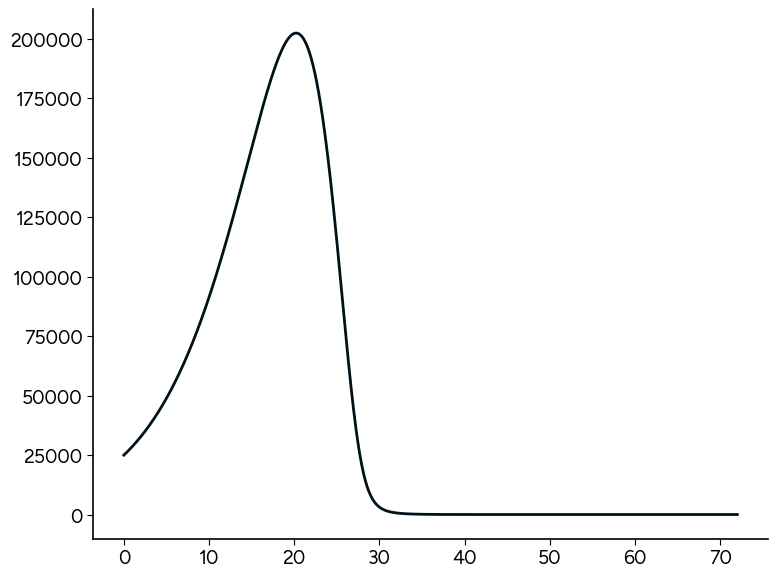

In [240]:
plt.plot(teval,gTime)


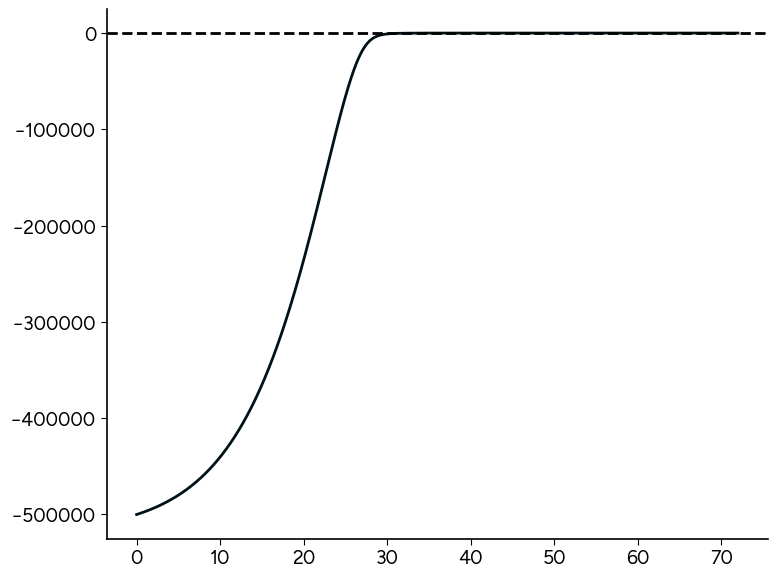

In [241]:
plt.plot(teval,-alphaTime)
plt.axhline(0,ls="--",color="black")

In [35]:
fullFitArray = np.load("data/fullFitArray_2.npy")
qssFitArray = np.load("data/qssFitArray_2.npy")

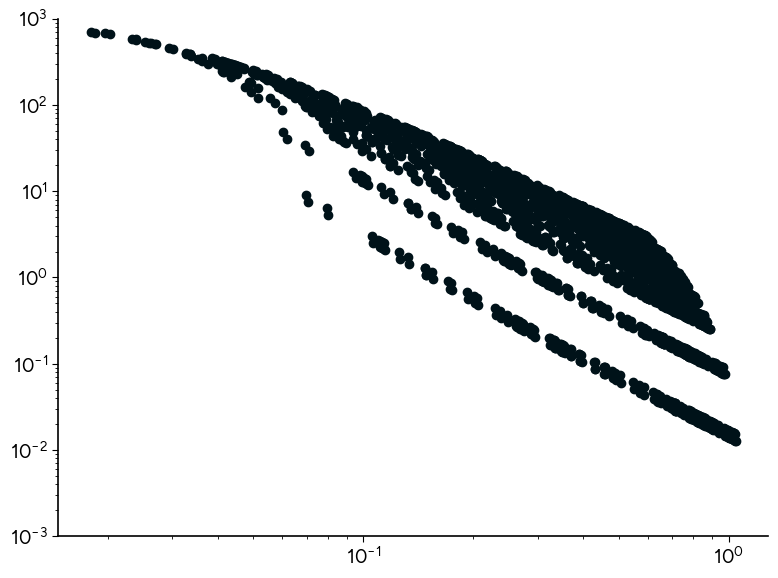

In [42]:
plt.scatter(fullFitArray[:,:,0].flatten(),qssFitArray[:,:,0].flatten())

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e-3,1e3)
plt.show()

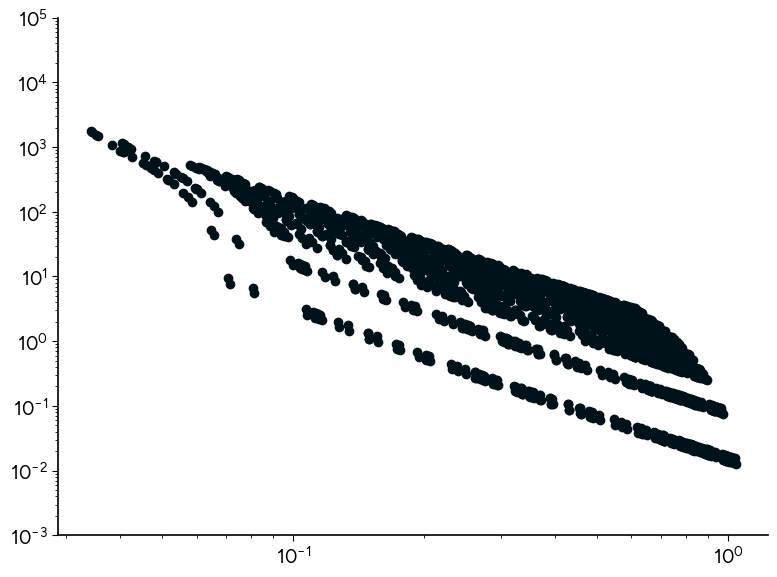

In [44]:
plt.scatter(fullFitArray[:,:,1].flatten(),qssFitArray[:,:,1].flatten())

plt.xscale("log")
plt.yscale("log")

plt.ylim(1e-3,1e5)
plt.show()

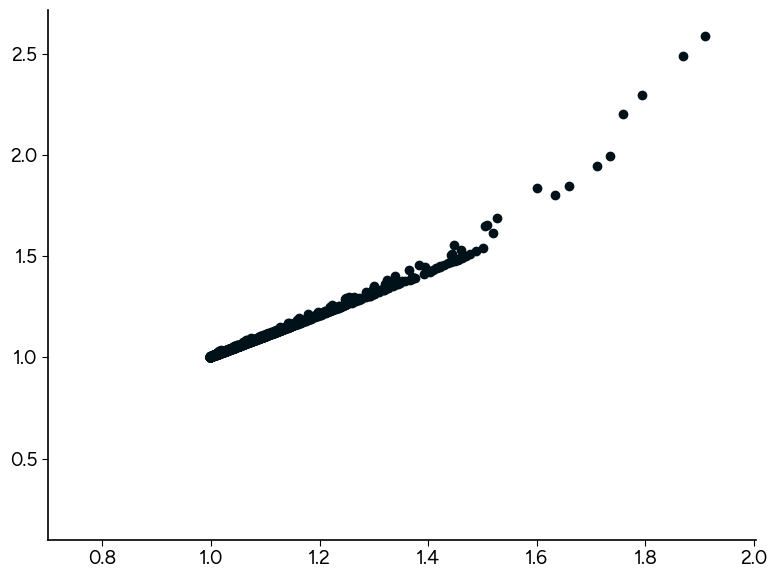

In [55]:
plt.scatter((fullFitArray[:,:,1]/fullFitArray[:,:,0]).flatten(),(qssFitArray[:,:,1]/qssFitArray[:,:,0]).flatten())

# plt.xscale("log")
# plt.yscale("log")

plt.ylim(0.1,)
plt.xlim(0.7,)

plt.show()